# Table of contents  <a name="toc"></a>
1. [Data](#data)
    1. [Loading data](#loadingdata)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn
import scipy
from scipy.optimize import minimize,least_squares
import copy as copy
import time as tpy
import glob
import os
import pandas as pd
import pickle
from scipy.stats import wilcoxon as wilcoxon

# seaborn.set()

# DATA <a name="data"></a>

* refs: references
* poss: positions
* dec_vels: decoded velocities
* int_vels: intended velocities
* emgs: filtered EMGs
* Ws: weiner filter
* Hs: other filter
* alphas: learning rate
* pDs: penalty on decoder terms
* times: time
* conditions: which condition are we doing

UNPACKING: 

refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1

NOTE: 

* **CONDITIONS** = array(['D_1', 'D_2', 'D_5', 'D_6', 'D_3', 'D_4', 'D_7','D_8']
* **LEARNING RATES:** alpha = 0.25 and 0.75; alpha = 0.25 for D1, D2, D5, D6; alpha = 0.75 for D3, D4, D7, D8
* **SMOOTHBATCH:** W_next = alpha*W_old + ((1 - alpha) * W_calc)

* **DECODER INIT:** pos for D1 - D4, neg for D5 - D8

* **PENALTY TERM:** $\lambda_E$ = 1e-6 for all, $\lambda_F$ = 1e-7 for all, $\lambda_D$ = 1e-3 for 1, 3, 5, 7 and 1e-4 for 2, 4, 6, 8 


| DECODER | ALPHA | PENALTY | DEC INIT |
| --- | --- | --- | --- |
| 1 | 0.25 | 1e-3 | + |
| 2 | 0.25 | 1e-4 | + |
| 3 | 0.75 | 1e-3 | + |
| 4 | 0.75 | 1e-4 | + |
| 5 | 0.25 | 1e-3 | - |
| 6 | 0.25 | 1e-4 | - |
| 7 | 0.75 | 1e-3 | - |
| 8 | 0.75 | 1e-4 | - |


## Loading data <a name="loadingdata"></a>

back to top: [TOC](#toc)

In [2]:
path = '/Users/mmadduri/OneDrive - UW/PhD_Research/Data/cphs-pilots'
#with open(path + '/cphs_data_block1.pickle', 'rb') as handle:
with open('cphs_data_block1.pickle', 'rb') as handle:
    refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1 = pickle.load(handle)
keys = ['METACPHS_S106', 'METACPHS_S107','METACPHS_S108', 'METACPHS_S109', 'METACPHS_S110', 'METACPHS_S111', 'METACPHS_S112']

#with open(path + '/cphs_data_block2.pickle', 'rb') as handle:
with open('cphs_data_block2.pickle', 'rb') as handle:
    refs_block2, poss_block2, dec_vels_block2, int_vel_block2, emgs_block2, Ws_block2, Hs_block2, alphas_block2, pDs_block2, times_block2, conditions_block2 = pickle.load(handle)
keys = ['METACPHS_S106', 'METACPHS_S107','METACPHS_S108', 'METACPHS_S109', 'METACPHS_S110', 'METACPHS_S111', 'METACPHS_S112']


The ones that were originally separated and printed

In [3]:
key = keys[0]

print("Alphas")
alphas = alphas_block1[key]
print(alphas)

print("\nConditions")
# Notice that conditions are presented in a random order!
conds = conditions_block2[key]
print(conds)

print("\nPenalty on decoder terms")
pDs = pDs_block1[key]
print(pDs)

Alphas
[0.25 0.25 0.25 0.25 0.75 0.75 0.75 0.75]

Conditions
['D_1' 'D_2' 'D_5' 'D_6' 'D_3' 'D_4' 'D_7' 'D_8']

Penalty on decoder terms
[0.001  0.0001 0.001  0.0001 0.001  0.0001 0.001  0.0001]


In [4]:
print("Decoded velocities shape:")
print((dec_vels_block1['METACPHS_S106']).shape)
#(8, 20770, 2)
#8 trials, 20770 somethings, then the x2 is X and Y?? 
# ^This is just block 1 so the x2 shouldn't be the 2nd block

print("\nTime array shape:")
print(times_block1['METACPHS_S106'].shape)

Decoded velocities shape:
(8, 20770, 2)

Time array shape:
(8, 20770)


The ones I strictly care about
- dec_vels: decoded velocities
- int_vels: intended velocities
- emgs: filtered EMGs
- __Ws: weiner filter: THIS IS THE DECODER MATRIX D__
- Hs: other filter
- alphas: learning rate
- pDs: penalty on decoder terms
- times: time

In [5]:
print("EMG input signal shape")
print(emgs_block1['METACPHS_S106'].shape)

EMG input signal shape
(8, 20770, 64)


Wiener Filter (Decoder)

In [6]:
Ws_block1.keys()

dict_keys(['METACPHS_S106', 'METACPHS_S107', 'METACPHS_S108', 'METACPHS_S109', 'METACPHS_S110', 'METACPHS_S111', 'METACPHS_S112'])

In [7]:
(Ws_block1['METACPHS_S106']).shape

(8, 20770, 2, 64)

Let's look at just 1 of the decoders over time

In [8]:
t = (times_block1['METACPHS_S106'])[0, :]

# DECODERS
decoder_106_0_0 = (Ws_block1['METACPHS_S106'])[0, :, 0, 0]
decoder_106_1_0 = (Ws_block1['METACPHS_S106'])[0, :, 1, 0]
decoder_107_0_0 = (Ws_block1['METACPHS_S107'])[0, :, 0, 0]
decoder_108_0_0 = (Ws_block1['METACPHS_S108'])[0, :, 0, 0]
decoder_109_0_0 = (Ws_block1['METACPHS_S109'])[0, :, 0, 0]

# DECODED VELOCITIES
dec_vel_106_0 = (dec_vels_block1['METACPHS_S106'])[0, :, 0]
dec_vel_106_1 = (dec_vels_block1['METACPHS_S106'])[0, :, 1]

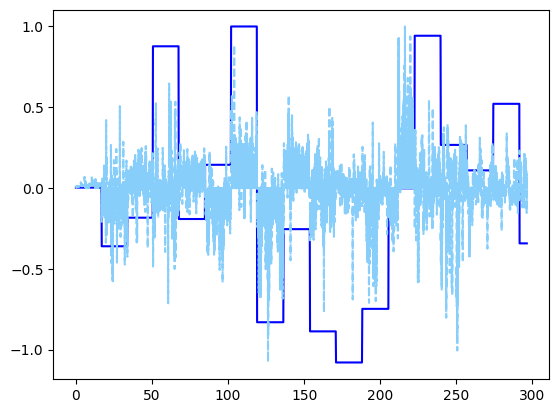

In [9]:
plt.plot(t, decoder_106_0_0/max(decoder_106_0_0), color='blue')
plt.plot(t, dec_vel_106_0/max(dec_vel_106_0), color='lightskyblue', linestyle='--')

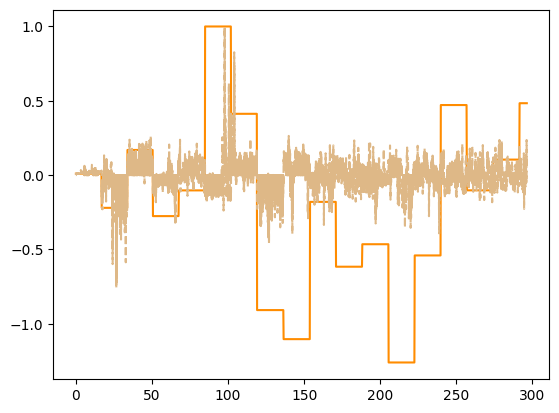

In [10]:
plt.plot(t, decoder_106_1_0/max(decoder_106_1_0), color='darkorange')
plt.plot(t, dec_vel_106_1/max(dec_vel_106_1), color='burlywood', linestyle='--')

Now let's see how the decoder varies (or hopefully does not) over the 64 channels

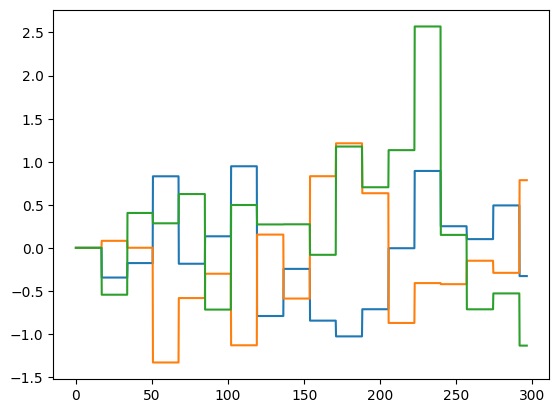

In [11]:
for i in range(3):
    plt.plot(t, (Ws_block1['METACPHS_S106'])[0, :, 0, i])

... No clear/visible relation between the 64 channels... which do I use?

In [13]:
Ws_block1['METACPHS_S106'].shape

(8, 20770, 2, 64)

In [15]:
Ws_block1['METACPHS_S106'][0, -1, :, :]

array([[-0.32458238,  0.78710202, -1.13064469,  0.09961173,  0.56165646,
        -0.24650703, -0.86161491,  0.12718564, -0.11235281,  0.20318404,
         1.15551718,  0.07585424, -0.01755645,  0.23056578, -0.27874941,
         0.27895292, -0.75436139, -0.33691808,  0.33585015, -0.24195462,
        -0.38407452, -0.74810009,  0.16333584, -0.34216991, -0.4373788 ,
         0.42069912,  0.1896985 ,  0.78022586,  0.55925573,  0.7654639 ,
        -0.15663377, -0.34525123,  0.09965524,  0.84286773,  0.34199493,
         0.50705988, -0.53737744, -1.10017675, -0.21991012,  0.13389909,
         0.17625027, -0.43154773, -0.82309803, -1.41234256,  0.56226322,
        -0.48508076, -0.33549858,  0.22988338,  0.43640069, -0.76982188,
         0.3957098 ,  0.61589728, -0.25357062,  0.1112628 ,  0.43995781,
        -0.12010574,  1.18935692, -0.47077885, -1.56205184, -0.35154533,
         0.35919301, -0.67310322,  0.27185368,  0.09497528],
       [ 0.26137261, -0.0373442 , -0.622487  , -0.22443677, -0.

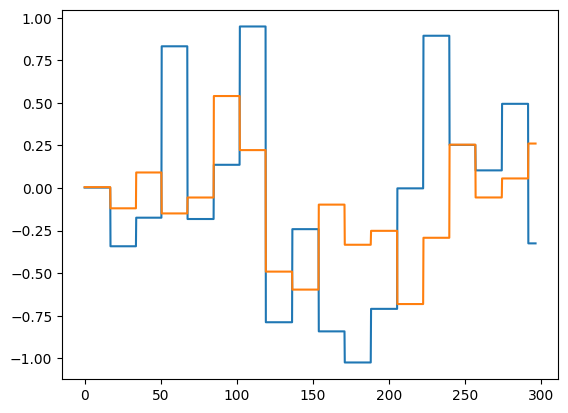

In [24]:
plt.plot(t, (Ws_block1['METACPHS_S106'])[0, :, 0, 0])
plt.plot(t, (Ws_block1['METACPHS_S106'])[0, :, 1, 0])

## Norms
1. Entry-wise matrix norms
- L21, Lpq, Frobenius, Max
2. Schatten norms (applying the p-norm to the vector of singular values)
- Note that p=2 is just the Frobenius norm, p=1 is just the nuclear (AKA trace) norm
3. Cut norms (considering how close the matrix is to being a bipartite graph)
- Yah idk this is related to graph stuff so maybe isn't too relevant
4. Built into numpy: np.linalg.norm(A, ord=___)
- None (default) = Frobenius norm
- fro = Also frobenius norm
- nuc = Nuclear norm
- inf = "max(sum(abs(x), axis=1))"
- -inf = "min(sum(abs(x), axis=1))"
- 1 = "max(sum(abs(x), axis=0))"
- -1 = "min(sum(abs(x), axis=0))"
- 2 = largest singular value (AKA 2-norm)
- -2 = smallest singular value
5. Other
- eigvals
- det
- slogdet (Compute the sign and (natural) logarithm of the determinant of an array)
- eig (Compute the eigenvalues and right eigenvectors of a square array)
- svd
## Clustering (in SKLearn)
1. AffinityPropagation
2. AgglomerativeClustering
3. Birch
4. DBSCAN
5. FeatureAgglomeration
6. KMeans
7. BisectingKMeans
8. MiniBatchKMeans
9. MeanShift
10. OPTICS
11. SpectralClustering
12. SpectralBiclustering
13. SpectralCoclustering

In [ ]:
#X = ref, Y = pos
#td_error = np.linalg.norm(X - Y, axis=1)

In [2]:
# Don't bother trying to run the code from below, it's just for reference
assert(1==0)

AssertionError: 

## Decoder Distances

In [ ]:
D_last = np.zeros((2, len(keys), len(conds), 2, 64)) # make an arry of the last decoders
for iK, key in enumerate(keys):
    # BLOCK 1
    b = 0
    D_last[b, iK] = np.mean(Ws_block1[key][:, update_ix, :, :][:, -3:], axis = 1) # average last 3 decoders
    
    # BLOCK 2
    b = 1
    D_last[b, iK] = np.mean(Ws_block2[key][:, update_ix, :, :][:, -3:], axis = 1)# average last 3 decoders

# get the last decoder for all pos init trials
Dp_all = D_last[:, :, pos_init] # 2 x 7 x 4 x 2 x 64
assert(Dp_all.shape == (2, len(keys), len(pos_init), 2, 64))

# get the last decoder for all neg init trials
Dn_all = D_last[:, :, neg_init]
assert(Dn_all.shape == (2, len(keys), len(pos_init), 2, 64))

# get last positive init decoder per person
Dp_subj = np.mean(D_last[:, :, pos_init], axis = (0, 2)) # 7 x 2 x 64
assert(Dp_subj.shape == (len(keys), 2, 64))

# get last negative init decoder per person
Dn_subj = np.mean(D_last[:, :, neg_init], axis = (0, 2))
assert(Dp_subj.shape == (len(keys), 2, 64))

# this takes the ||.||_F^2 of the difference between each decoder and the average of the final 
dpp = np.linalg.norm(Dp_all - Dp_subj[np.newaxis,:, np.newaxis], 'fro', axis=(-2, -1))**2 # (2, 7, 4)
dpn = np.linalg.norm(Dp_all - Dn_subj[np.newaxis,:, np.newaxis], 'fro', axis=(-2, -1))**2
dnn = np.linalg.norm(Dn_all - Dn_subj[np.newaxis,:, np.newaxis], 'fro', axis=(-2, -1))**2
dnp = np.linalg.norm(Dn_all - Dp_subj[np.newaxis,:, np.newaxis], 'fro', axis=(-2, -1))**2


# making sure that this is the squared euclidean distance
dpp1 = np.sum((Dp_all - Dp_subj[np.newaxis,:, np.newaxis])**2, axis = (-2, -1))
assert(np.allclose(dpp1, dpp))

# take average per subject --> Was changed to median
dpp = np.median(dpp,axis=(0, 2))
dpn = np.median(dpn,axis=(0, 2))
dnn = np.median(dnn,axis=(0, 2))
dnp = np.median(dnp,axis=(0, 2))